In [1]:
import pandas as pd
import geopandas
import json
import os
from shapely.geometry import Point
import difflib
from geopy.distance import vincenty
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
inline_rc = dict(mpl.rcParams)


Ce notebook est globalement un duplicat de l'audit, mais réduit sur un résau opendata

In [2]:
in_folder = "audits/2019_05/data/"
in_folder = "../data/"
out_folder = "/tmp"

filter_network = "Pays de l'Ourcq"
filter_network = "RATP"
filter_network = "CIF"

## Nombre de lignes

In [3]:
# on charge les lignes dans les deux sources
gtfs_lines = pd.read_csv(os.path.join(in_folder, "gtfs_routes.txt"), dtype=str)
gtfs_lines = gtfs_lines[gtfs_lines['route_type'] == '3']

osm_lines = pd.read_csv(os.path.join(in_folder, "osm-transit-extractor_lines.csv"), dtype=str)
osm_lines = osm_lines[osm_lines['mode'] == 'bus']

## Nombre de routepoints

In [4]:
gtfs_routepoints = pd.read_csv(os.path.join(in_folder,"opendata_routepoints.csv"), dtype=str)
gtfs_routepoints_RATP = gtfs_routepoints[gtfs_routepoints["agency_name"] == filter_network]
tt = len(gtfs_routepoints_RATP) / len(gtfs_routepoints) * 100
print("les routepoints de ce réseau représentent {} % de la totalité des routepoints opendata".format(tt))

les routepoints de ce réseau représentent 3.20622197531844 % de la totalité des routepoints opendata


In [5]:
gtfs_routepoints = gtfs_routepoints[gtfs_routepoints["agency_name"] == filter_network]

# Mesures qualitatives

In [6]:
quali_osm_routepoints = pd.read_csv(os.path.join(in_folder, "osm_routepoints_for_matching.csv"), dtype=str)
for c in quali_osm_routepoints.columns:
    new_col = "osm_" + c
    quali_osm_routepoints.rename(columns={c: new_col}, inplace=True)

#gtfs_routepoints = pd.read_csv(os.path.join(in_folder, "opendata_routepoints.csv"), dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
print("On a {:d} routepoints dans OSM et {:d} routepoints dans le GTFS".format(quali_osm_routepoints.shape[0], gtfs_routepoints.shape[0]))

On a 51164 routepoints dans OSM et 3232 routepoints dans le GTFS


In [7]:
quali_osm_routepoints_RATP = quali_osm_routepoints[quali_osm_routepoints["osm_network"] == filter_network]
tt = len(quali_osm_routepoints_RATP) 
print("En filtrant sur le réseau, on a {} routepoints dans OSM".format(tt))


En filtrant sur le réseau, on a 6 routepoints dans OSM


In [8]:
quali_gtfs_routepoints = gtfs_routepoints.copy().fillna("")
quali_gtfs_routepoints = quali_gtfs_routepoints[quali_gtfs_routepoints['gtfs_ZDEr_ID_REF_A'] != '']
quali_osm_routepoints = quali_osm_routepoints[quali_osm_routepoints['osm_osm:ref:FR:STIF'] != '']
quali_osm_routepoints = quali_osm_routepoints[quali_osm_routepoints['osm_osm:ref:FR:STIF:ExternalCode_Line'] != '']

#on fusionne sur les codes d'arrêts et les codes de lignes
quali_routepoints = quali_gtfs_routepoints.merge(
                    quali_osm_routepoints, how='inner', 
                    right_on=["osm_osm:ref:FR:STIF", "osm_osm:ref:FR:STIF:ExternalCode_Line"],
                    left_on=["gtfs_ZDEr_ID_REF_A", "gtfs_route_id"]
               )
quali_routepoints.fillna("", inplace=True)

def compute_similarity_lower(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1.lower(), elem2.lower()).ratio()

def compute_similarity(elem1, elem2):
    return difflib.SequenceMatcher(None, elem1, elem2).ratio()

#on fusionne sur les terminus de lignes
quali_routepoints['destination_confidence'] = quali_routepoints[['osm_destination','gtfs_dest_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
#quali_routepoints['destination_confidence'].hist()

In [9]:
#Pour la suite, on ne conserve que les routepoints qui matchent à 60% et plus
quali_routepoints_filtered = quali_routepoints[quali_routepoints['destination_confidence'] >= 0.6].copy()
print("{:d} routepoints matchant à plus de 60%".format(quali_routepoints_filtered.shape[0]))

tt = len(quali_routepoints_filtered) * 100.0 / len(gtfs_routepoints)
"Pourcentage de routepoints qu'on considère pour la suite : {}".format(tt)

693 routepoints matchant à plus de 60%


"Pourcentage de routepoints qu'on considère pour la suite : 21.441831683168317"

## Réseaux

In [10]:
quali_routepoints_gb = pd.DataFrame(quali_routepoints_filtered.groupby('osm_network').size()).reset_index()
quali_routepoints_gb

,osm_network,0
0,Keolis CIF,21
1,Les Courriers de l'Île-de-France,670
2,Les Courriers de l’Île-de-France,2


## Code de ligne

/home/pclf/.local/share/virtualenvs/audit_routepoints-xp16w_6c/lib/python3.5/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pclf/.local/share/virtualenvs/audit_routepoints-xp16w_6c/lib/python3.5/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


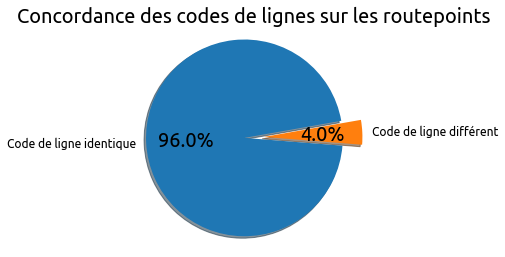

In [11]:
# différences sur les codes de ligne
quali_routepoints_filtered['line_code_confidence'] = quali_routepoints_filtered[['osm_code','gtfs_route_short_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["line_code_confidence_rounded"] = quali_routepoints_filtered["line_code_confidence"].round(1) * 100

routepoints_count_total = quali_routepoints_filtered.shape[0]
routepoints_count_with_perfect_line_mapping = quali_routepoints_filtered[quali_routepoints_filtered["line_code_confidence_rounded"] == 100].shape[0]
routepoints_count_with_different_line_mapping = routepoints_count_total - routepoints_count_with_perfect_line_mapping
labels = 'Code de ligne identique', 'Code de ligne différent'


sizes = [routepoints_count_with_perfect_line_mapping/routepoints_count_total * 100, 
         routepoints_count_with_different_line_mapping/routepoints_count_total * 100]
explode = (0, 0.2)

mpl.rcParams.update(inline_rc) # reset du style 
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 22
fig1, ax1 = plt.subplots()
ax1.set_title('Concordance des codes de lignes sur les routepoints')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig(os.path.join(out_folder, '11_routepoints_line_code_mapping_pie_{}.png'.format(filter_network)), bbox_inches='tight')

In [12]:
#le détail
tt = quali_routepoints_filtered[quali_routepoints_filtered["line_code_confidence_rounded"] < 100][['line_code_confidence', 'osm_code', 'gtfs_route_short_name']]
tt.drop_duplicates()

,line_code_confidence,osm_code,gtfs_route_short_name
1012,0.888889,12 ZI,12ZI


## Noms des arrêts

In [13]:
quali_routepoints_filtered['name_confidence'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity(*x), axis=1)
quali_routepoints_filtered["name_confidence_rounded"] = quali_routepoints_filtered["name_confidence"].round(1) * 100
quali_routepoints_filtered['name_confidence_lower'] = quali_routepoints_filtered[['osm_name','gtfs_stop_name']].apply(lambda x: compute_similarity_lower(*x), axis=1)
quali_routepoints_filtered["name_confidence_lower_rounded"] = quali_routepoints_filtered["name_confidence_lower"].round(1) * 100

routepoints_count = quali_routepoints_filtered.shape[0]
borne_identique = 0.9
borne_proche = 0.7
identiques = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] >= borne_identique].shape[0]
proches = quali_routepoints_filtered[
    (quali_routepoints_filtered["name_confidence"] < borne_identique) & 
    (quali_routepoints_filtered["name_confidence"] >= borne_proche)].shape[0]
differents = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence"] < borne_proche].shape[0]

identiques_lower = quali_routepoints_filtered[quali_routepoints_filtered['name_confidence_lower'] >= borne_identique].shape[0]
proches_lower = quali_routepoints_filtered[
    (quali_routepoints_filtered["name_confidence_lower"] < borne_identique) & 
    (quali_routepoints_filtered["name_confidence_lower"] >= borne_proche)].shape[0]
differents_lower = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence_lower"] < borne_proche].shape[0]

#quali_routepoints_filtered[quali_routepoints_filtered['name_confidence'] <= borne_proche].sort_values("name_confidence")

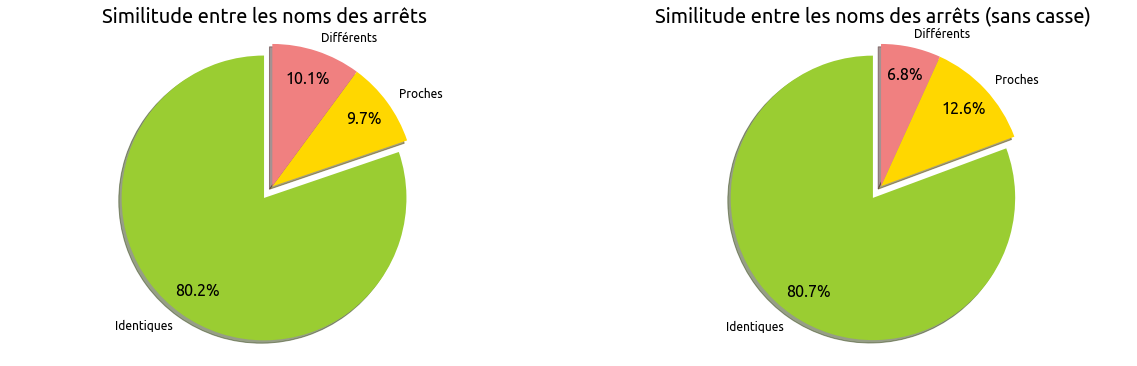

In [14]:
sizes = [identiques/routepoints_count * 100, 
         proches/routepoints_count * 100,
         differents/routepoints_count * 100]
sizes_lower = [identiques_lower/routepoints_count * 100, 
         proches_lower/routepoints_count * 100,
         differents_lower/routepoints_count * 100]
explode = (0.1, 0, 0)
colors = ['yellowgreen', 'gold', 'lightcoral']
labels = 'Identiques', 'Proches', 'Différents'

fig1 = plt.figure(figsize=(20, 6))
ax1 = fig1.add_subplot(121)

plt.rcParams['font.size'] = 16

ax1.set_title('Similitude entre les noms des arrêts')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=colors,
        shadow=True, startangle=90, pctdistance=0.8)
ax1.axis('equal')  


ax1 = fig1.add_subplot(122)

ax1.set_title('Similitude entre les noms des arrêts (sans casse)')
ax1.pie(sizes_lower, explode=explode, labels=labels, autopct='%1.1f%%',
        colors=colors,
        shadow=True, startangle=90, pctdistance=0.8)
ax1.axis('equal') 

plt.savefig(os.path.join(out_folder,'12_routepoints_name_mapping_pie_all_{}.png'.format(filter_network)), bbox_inches='tight')

In [15]:
#le détail
tt = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence"] >= borne_proche][['name_confidence_lower', 'osm_name','gtfs_stop_name']]
#tt.drop_duplicates()

In [16]:
tt = quali_routepoints_filtered[quali_routepoints_filtered["name_confidence_lower"] <= borne_proche][['name_confidence_lower', 'osm_name','gtfs_stop_name']]
#tt.drop_duplicates()

## Position des arrêts

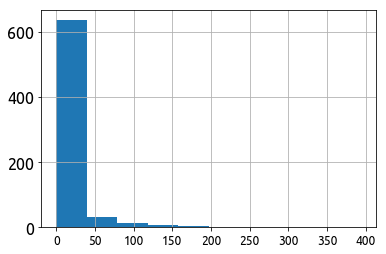

In [17]:
def compute_distance(row):
    dist = vincenty(
        (float(row['osm_lat']), float(row['osm_lon'])), 
        (float(row['gtfs_stop_lat']), float(row['gtfs_stop_lon']))
    )
    return dist.meters
   
quali_routepoints_filtered['distance'] = quali_routepoints_filtered.apply(compute_distance, axis=1)
quali_routepoints_filtered['distance'].hist()

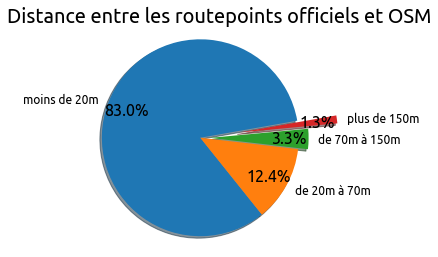

In [18]:
routepoints_count = quali_routepoints_filtered.shape[0]
labels = 'moins de 20m', 'de 20m à 70m', 'de 70m à 150m', 'plus de 150m'
count_moins_20 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] < 20].shape[0]
count_20_70 = quali_routepoints_filtered[(quali_routepoints_filtered["distance"] >= 20) & (quali_routepoints_filtered["distance"] < 70)].shape[0]
count_70_150 = quali_routepoints_filtered[(quali_routepoints_filtered["distance"] >= 70) & (quali_routepoints_filtered["distance"] < 150)].shape[0]
count_plus_150 = quali_routepoints_filtered[quali_routepoints_filtered["distance"] >= 150].shape[0]

sizes = [count_moins_20/routepoints_count * 100, 
         count_20_70/routepoints_count * 100,
         count_70_150/routepoints_count * 100,
         count_plus_150/routepoints_count * 100]
explode = (0, 0, 0.1, 0.4)

fig1, ax1 = plt.subplots()
plt.rcParams['font.size'] = 16

ax1.set_title('Distance entre les routepoints officiels et OSM')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=10, pctdistance=0.8)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(os.path.join(out_folder,'14_routepoints_distance_pie_V2_{}.png'.format(filter_network)), bbox_inches='tight')

In [19]:
print("Distance max : {:f}".format(quali_routepoints_filtered['distance'].max()))
print("Distance moyenne : {:f}".format(quali_routepoints_filtered['distance'].mean()))
print("Distance médiane : {:f}".format(quali_routepoints_filtered['distance'].median()))

routepoints_bad_position = quali_routepoints_filtered[quali_routepoints_filtered['distance'] > 70].copy()
print("Nombre de routepoints à plus de 70m : {:d}".format(len(routepoints_bad_position)))

print("Nombre de stoppoints du GTFS à plus de 70m : {:d}".format(
    len(routepoints_bad_position.groupby(['gtfs_stop_id'])[["distance"]].count()))
)

Distance max : 393.461747
Distance moyenne : 15.801758
Distance médiane : 6.930927
Nombre de routepoints à plus de 70m : 32
Nombre de stoppoints du GTFS à plus de 70m : 20


In [20]:
routepoints_bad_position_gb = pd.DataFrame(routepoints_bad_position.groupby('gtfs_route_id').size())
routepoints_bad_position_gb.rename(columns={0: 'count_routepoints_bad_pos'}, inplace=True)
routepoints_bad_position_gb.sort_values(by='count_routepoints_bad_pos', inplace=True, ascending=False)
routepoints_bad_position_gb

,count_routepoints_bad_pos
gtfs_route_id,
014115086:Vitavil,8
014014032:32,6
014014011:11,5
014014320:32A,4
014014071:71,2
014014115:115,2
014014039:39,1
014014099:Gbus,1
014014104:R104,1


In [21]:
routepoints_bad_position.sort_values(by='distance', inplace=True, ascending=False)
routepoints_bad_position[routepoints_bad_position['distance']>=150][['distance', 'gtfs_route_id','osm_destination', 'osm_name','gtfs_stop_name']]

,distance,gtfs_route_id,osm_destination,osm_name,gtfs_stop_name
609,393.461747,014014039:39,Vert Galant RER B,Rue du Sausset,Rue de Sausset
1089,230.807809,014014218:18,Collège Gérard Philipe,Entrepreneurs,Entrepreneurs
200,180.548013,014014011:11,Victor Basch Goussainville,Le Moulin,Le Moulin
487,180.548013,014014032:32,Victor Basch (Goussainville),Le Moulin,Le Moulin
180,172.875911,014014011:11,Victor Basch Goussainville,Carrefour de l'Europe,Carrefour de l Europe
1305,172.875911,014014320:32A,Goussainville - La Charmeuse,Carrefour de l'Europe,Carrefour de l Europe
775,156.444166,014014071:71,Villeparisis - Mitry-le-Neuf RER,Châteaubriant,Châteaubriant
984,155.612654,014014115:115,Gonesse - Collège Philippe Auguste,Le Moulin,Le Moulin
486,155.612654,014014032:32,Aéroville,Le Moulin,Le Moulin
